In [3]:
from qiskit import *
from qiskit.circuit.library import *

In [28]:
def ent_block(n):
    two = TwoLocal(n,[],'cz','sca',reps=1)
    qc = QuantumCircuit(n)
    qc += two
    qc.data.pop(-1)
    print(qc.decompose().draw())

In [99]:
def ent_block(n):
    two = TwoLocal(n,[],'cz','circular',reps=1)
    qc = QuantumCircuit(n)
    # qc.cz(0,5)
    x = qc.compose(two.decompose())
    x.data.pop(0)
    x.cz(0,n-1)
    return x

In [102]:
ent_block(5).draw()

q_0: ─■───────────■─
      │           │ 
q_1: ─■──■────────┼─
         │        │ 
q_2: ────■──■─────┼─
            │     │ 
q_3: ───────■──■──┼─
               │  │ 
q_4: ──────────■──■─

In [121]:
def generator(n,k):
    two = TwoLocal(n,['ry'],ent_block(5),'full',reps=k,insert_barriers=True)
    qc = QuantumCircuit(n)
    qc += two 
    # print(qc.decompose().draw('mpl'))
    return qc.decompose()

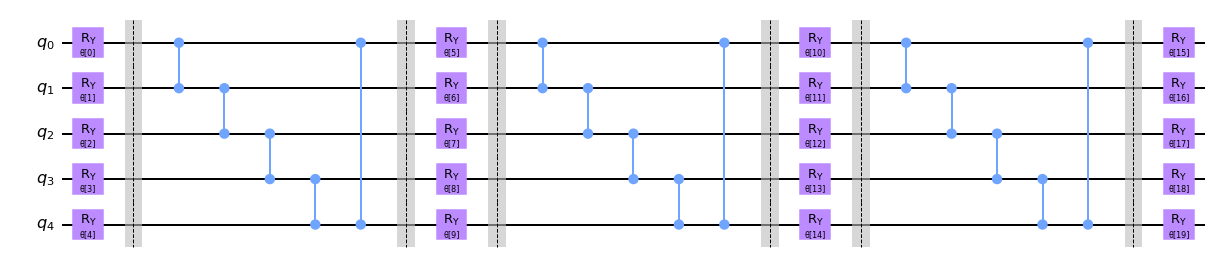

In [122]:
generator(5,3).draw('mpl')

In [167]:
def encoding_block(n,k):
    qc = QuantumCircuit(n)
    two = TwoLocal(n,['h','rz','ry'],['cx','cz'],['full'],reps=k)
    qc += two
    qc.decompose().draw('mpl')
    

In [171]:
def discriminator(n,k):
    two = TwoLocal(n,['rz','ry'],['rxx','rzz'],'full',reps=k,insert_barriers=True)
    qc = QuantumCircuit(n)
    qc += two 
    return qc.decompose()

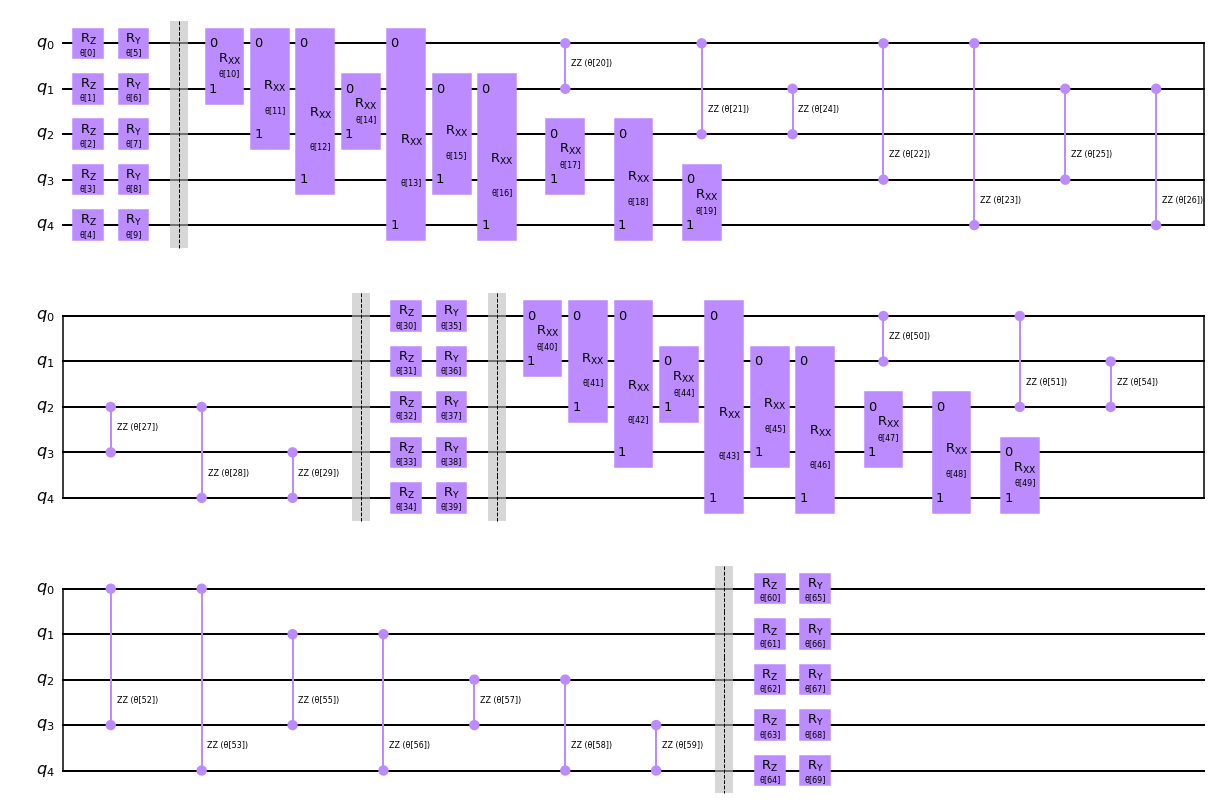

In [172]:
discriminator(5,2).draw('mpl')

In [165]:
from typing import Union, Optional
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Sequential
from sklearn.metrics import roc_curve, auc, roc_auc_score
# import tensorflow_quantum as tfq
import matplotlib.pyplot as plt

def get_circuit_qubits(circuit):
    all_qubits = set()
    for moment in circuit:
        for op in moment:
            all_qubits |= set(op._qubits)
    return sorted(list(all_qubits))

def plot_stacked_roc_curve(fpr_list:list[np.ndarray], 
                   tpr_list:list[np.ndarray], labels:list[str]=None, title:str='ROC Curve', with_auc:bool=True):
    """Plots multiple roc curves stacked together
    
    Args:
        fpr: list/array of numpy array
            A collection of arrays containing the false positive rates for 
            different experiments
        tpr: list/array of numpy array
            A collection of arrays containing the false positive rates for 
            different experiments
        labels: list of str, default = None
            List of labels for different experiments.
        title: str, default = 'ROC Curve'
            Title of the plot
        with_auc: True or False
            Whether to include the auc in the labels

    Returns:
        A matplotlib plot of the stacked roc curve
    """     
    assert len(fpr_list) == len(tpr_list)
    n = len(fpr_list)
    if labels is None:
        labels = ['']*n
    assert len(labels) == n
    from sklearn.metrics import roc_curve, auc
    import matplotlib.pyplot as plt
    plt.clf()
    plt.rcParams["font.weight"] = "bold"
    plt.xlabel("Signal Efficiency", fontsize=18,fontweight='bold')
    plt.ylabel("Background Rejection", fontsize=18,fontweight='bold')
    plt.title(title, fontsize=16,fontweight='bold')
    plt.xlim(0.0, 1.0)
    plt.ylim(0.0, 1.0)
    plt.grid(color='gray', linestyle='--', linewidth=1)  
    for fpr,tpr,label in zip(fpr_list, tpr_list, labels):
        if with_auc:
            roc_auc = auc(fpr, tpr)
            label += ', AUC={:.4f}'.format(roc_auc)
        plt.plot(tpr,1-fpr, linestyle='-',label=label,linewidth=2)
    plt.plot([0, 1], [1, 0], linestyle='--', color='black', label='Luck, AUC= 0.5')
    plt.legend(loc='best',prop={'size': 8})    
    return plt       


def plot_roc_curve(fpr:np.ndarray, tpr:np.ndarray, label:str='', title:str='ROC Curve', with_auc:bool=True):
    """Plots a roc curve
    
    Args:
        fpr: numpy array
            An array containing the false positive rates
        tpr: numpy array
            An array containing the true positive rates
        label: str
            Label of the curve
        title: str
            Title of the plot
        with_auc: True or False
            Whether to include the auc in the labels
    
    Returns:
        A matplotlib plot of the roc curve
    """        
    return plot_stacked_roc_curve([fpr], [tpr], [label], title=title, with_auc=with_auc)    
    

class QGAN(object):
    def __init__(self,generator_circuit:"QuantumCircuit",
                      discriminator_circuit:"QuantumCircuit",
                      encoding_circuit:"QuantumCircuit",
                      epochs:int=100,batch_size:int=10,
                      g_lr:float=1e-3,d_lr:float=1e-3, g_activation='tanh', 
                 d_activation=tf.keras.layers.LeakyReLU(alpha=0.2),
                 g_readout=None,
                 d_readout=None,                 
                 differentiator=None,
                 regularizer=None,
                 repetitions=None,                 
                 random_state:Optional[int]=None, 
                 name:str='QGAN', *arg, **args):
        # initialize hyperparameters first
        self.epochs = epochs
        self.batch_size = batch_size
        self.g_lr = g_lr
        self.d_lr = d_lr        
        self.g_activation = g_activation
        self.d_activation = d_activation
        self.differentiator = differentiator
        self.regularizer = regularizer
        self.repetitions = repetitions
        self.g_readout = g_readout
        self.d_readout = d_readout
        self.encoding_circuit = encoding_circuit
        # latent dimension is the same as number of features (= number of qubits)
        self.latent_dim = len(get_circuit_qubits(encoding_circuit))
        self.random_state = random_state
        self.set_random_state(self.random_state)
        # create generator and discriminator models from parameterized quantum circuit
        self.G = self.create_generator(generator_circuit)
        self.D = self.create_discriminator(discriminator_circuit)
        # create optimizers
        self.G_optimizer = tf.keras.optimizers.Adam(learning_rate=self.g_lr)
        self.D_optimizer = tf.keras.optimizers.Adam(learning_rate=self.d_lr)
        
        self.cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
        
        self.name = name
        
        print('Summary of Generator')
        self.G.summary()
        
        print('Summary of Discriminator')
        self.D.summary()
        
    @staticmethod
    def set_random_state(random_state=None):
        tf.random.set_seed(random_state)
        np.random.seed(random_state)        
        
    def create_generator(self, quantum_circuit:"QuantumCircuit"):
        generator = Sequential()
        # input layer for feeding classical data
        input_layer = tf.keras.layers.Input(shape=(self.latent_dim), dtype=tf.float32)
        # variational layer 
        qubits = get_circuit_qubits(quantum_circuit)
        if not self.g_readout:
            g_readout = [z(qubit) for qubit in qubits]
        else:
            g_readout = self.g_readout
        pqc_layer = PQC(quantum_circuit,
                        self.encoding_circuit,
                        g_readout,
                        repetitions=self.repetitions,
                        differentiator=self.differentiator,
                        regularizer=self.regularizer)
        # classical layer for processing quantum output
        output_layer = tf.keras.layers.Dense(self.latent_dim, activation=self.g_activation)
        
        # create generator model
        generator.add(input_layer)
        generator.add(pqc_layer)
        generator.add(output_layer)
        return generator
        
    def D_loss(self, real_output, fake_output):
        """Compute discriminator loss."""
        real_loss = self.cross_entropy(tf.ones_like(real_output), real_output)
        fake_loss = self.cross_entropy(tf.zeros_like(fake_output), fake_output)
        total_loss = real_loss + fake_loss
        return total_loss

    def G_loss(self, fake_output):
        """Compute generator loss."""
        return self.cross_entropy(tf.ones_like(fake_output), fake_output)
    
    def to_prob(self, x):
        """Convert discriminator output to probabilities"""
        return tf.divide(tf.add(x, 1), 2)
    
    def train_step(self, x_real, real_noise=0.0):
        """Training step for one epoch"""
        noise = tf.random.normal([self.batch_size, self.latent_dim])
        #x_real_w_noise = tf.add(x_real, tf.random.normal(shape=x_real.shape, 
        #                                           mean=0.0, 
        #                                           stddev=real_noise, dtype=x_real.dtype))
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            x_fake = self.G(noise, training=True)
            real_output = self.D(x_real, training=True)
            p_real = self.to_prob(real_output) 
            fake_output = self.D(x_fake, training=True)
            p_fake = self.to_prob(fake_output) 
            gen_loss = self.G_loss(p_fake)
            disc_loss = self.D_loss(p_real, p_fake)

        grad_gen = gen_tape.gradient(gen_loss, self.G.trainable_variables)
        grad_disc = disc_tape.gradient(disc_loss, self.D.trainable_variables)
        self.G_optimizer.apply_gradients(zip(grad_gen, self.G.trainable_variables))
        self.D_optimizer.apply_gradients(zip(grad_disc, self.D.trainable_variables))  
        return gen_loss, disc_loss
    
    @tf.function
    def generate_samples(self, batch_size):
        """Generates sample using random inputs."""
        z = tf.random.normal((batch_size, self.latent_dim))
        return self.G(z, training=False)  
    
    def predict(self, x):
        return self.D(x, training=False)
    
    @staticmethod
    def create_batches(x, batch_size, buffer_size=10000):
        batches = tf.data.Dataset.from_tensor_slices(x).shuffle(buffer_size).batch(batch_size)
        return batches
    
    def train(self, x, interactive_display=True):
        self.set_random_state(self.random_state)
        batches = self.create_batches(x, self.batch_size)
        #sample_size = x.shape[0]
        #z = tf.constant(tf.random.normal((sample_size, self.latent_dim)))
        g_metric = tf.keras.metrics.Mean()
        d_metric = tf.keras.metrics.Mean()
        fig = plt.figure(figsize=(16,9))
        g_loss_arr = []
        d_loss_arr = []
        epoch_arr = []
        
        for epoch in range(self.epochs):
            for batch in batches:
                gen_loss, disc_loss = self.train_step(batch)
                g_metric(gen_loss)
                d_metric(disc_loss)
                
            g_loss_arr.append(g_metric.result())
            d_loss_arr.append(d_metric.result())
            epoch_arr.append(epoch)
            if interactive_display:
                self.display_loss(g_loss_arr, d_loss_arr, epoch_arr)
            g_metric.reset_states()
            d_metric.reset_states()
        if not interactive_display:
            return g_loss_arr, d_loss_arr
        
    def test(self, x, y, plot=True):
        score = self.predict(x)
        fpr, tpr, thresholds = roc_curve(y, score)
        roc_auc = auc(fpr, tpr)
        if plot:
            return plot_roc_curve(fpr, tpr, 'QDCGAN')
        else:
            return roc_auc
        
    def display_loss(self, g_loss, d_loss, epochs):
        ax = plt.gca()
        ax.set_xlim(0, 1.1*epochs[-1])
        ax.cla()
        ax.plot(epochs, g_loss, label="Generator")
        ax.plot(epochs, d_loss, label="Discriminator")
        ax.set_xlabel('Epoch', fontsize=20)
        ax.set_ylabel('Binary Cross Entropy Loss', fontsize=20)
        ax.grid(True)
        ax.legend(fontsize=20)
        display(plt.gcf())
        clear_output(wait = True)    

In [174]:
g = generator(5,2)
d = discriminator(5,3)
encoding_circuit = encoding_block(5,3)

In [175]:
qgan = QGAN(g, d, encoding_circuit,
              epochs=100, d_lr=7e-3, g_lr=1e-3, g_activation='tanh', d_activation='linear',
              random_state=2)

TypeError: 'NoneType' object is not iterable

In [180]:
def lab1_ex6():
    # This time, we need 3 qubits and also add 3 classical bits in case we want to measure
    qc = QuantumCircuit(3,3) 
    qc.h(0)
    qc.cx(0,1)
    qc.cx(0,2)
    qc.x(0)
    qc.z(0)
    return qc

qc = lab1_ex6()
qc.draw() # we draw the circuit
qc.save_statevector()
sim = Aer.get_backend('aer_simulator')
result = sim.run(assemble(qc)).result()
state = result.get_statevector()
print("Qubit State = " + str(state))

Qubit State = [ 0.        +0.j -0.70710678+0.j  0.        +0.j -0.        +0.j
  0.        +0.j -0.        +0.j  0.70710678+0.j -0.        +0.j]
